In [1]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import shutil
import pandas as pd

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

### **Data Preparation (train)**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Copy the train data to colab storage to read the image faster in next step

import shutil

# Define the source and destination paths
source_folder = '/content/drive/My Drive/DSBA data/DSBA_S3/Deep Learning/kvasir_12k/aug_images/'
destination_folder = '/content/kvasir_image'

# Copy the entire folder,  overwriting the destination if it exists
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/kvasir_image'

In [9]:
X = np.zeros((12000, 256, 256, 3), dtype=np.uint8)
images_path = '/content/kvasir_image'

for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

### **Data Preparation (mask)**

In [5]:
# Copy the train data to colab storage to read the image faster in next step

import shutil

# Define the source and destination paths
source_folder = '/content/drive/My Drive/DSBA data/DSBA_S3/Deep Learning/kvasir_12k/aug_masks/'
destination_folder = '/content/kvasir_mask'

# Copy the entire folder,  overwriting the destination if it exists
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/kvasir_mask'

In [6]:
y = np.zeros((12000, 256, 256, 1), dtype=np.bool_)
mask_path = '/content/kvasir_mask'

for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

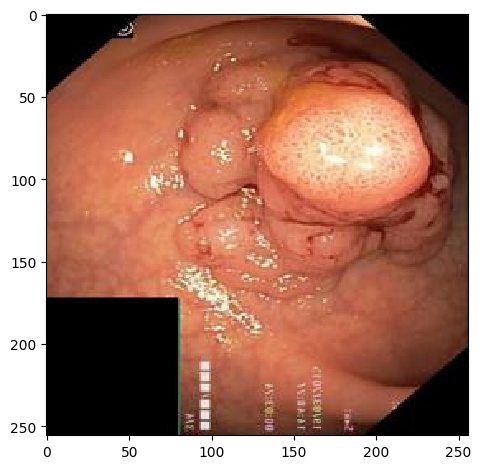

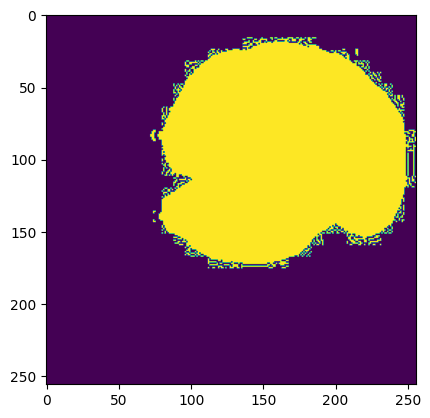

In [12]:
import random

image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))

### **Build The Model**

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"X_train.shape: {X_train.shape}\ny_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}\ny_test.shape: {y_test.shape}")

X_train.shape: (9000, 256, 256, 3)
y_train.shape: (9000, 256, 256, 1)
X_test.shape: (3000, 256, 256, 3)
y_test.shape: (3000, 256, 256, 1)


In [16]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(input)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)

    return x


#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p


#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = tf.keras.layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(n_classes, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, dtype=tf.float32) # Cast y_true to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32) # Cast y_pred to float32
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [21]:
input_shape = (256, 256, 3)
model_oriu = build_unet(input_shape, n_classes=1)
model_oriu.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model_oriu.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_39[0][0]']           
 g2D)                                                                                         

In [22]:
history0 = model_oriu.fit(X_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/20
282/282 [==============================] - 58s 183ms/step - loss: 1.6985 - accuracy: 0.7988 - iou_coef: 0.1341 - val_loss: 0.4079 - val_accuracy: 0.8285 - val_iou_coef: 0.1928
Epoch 2/20
282/282 [==============================] - 50s 177ms/step - loss: 0.4119 - accuracy: 0.8300 - iou_coef: 0.1709 - val_loss: 0.3650 - val_accuracy: 0.8395 - val_iou_coef: 0.1951
Epoch 3/20
282/282 [==============================] - 50s 178ms/step - loss: 0.3586 - accuracy: 0.8440 - iou_coef: 0.2147 - val_loss: 0.3420 - val_accuracy: 0.8477 - val_iou_coef: 0.1983
Epoch 4/20
282/282 [==============================] - 50s 178ms/step - loss: 0.3290 - accuracy: 0.8597 - iou_coef: 0.2555 - val_loss: 0.3000 - val_accuracy: 0.8718 - val_iou_coef: 0.2591
Epoch 5/20
282/282 [==============================] - 50s 178ms/step - loss: 0.2861 - accuracy: 0.8828 - iou_coef: 0.3301 - val_loss: 0.2557 - val_accuracy: 0.8989 - val_iou_coef: 0.3920
Epoch 6/20
282/282 [==============================] - 50s 178ms/s

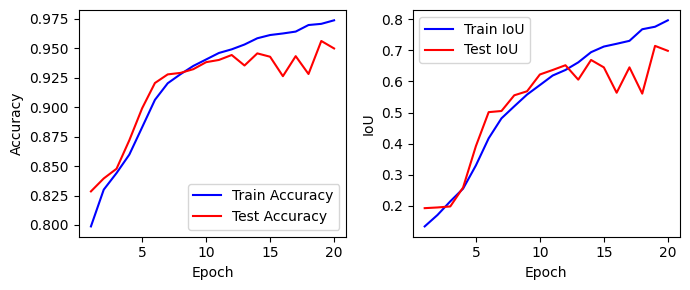

In [23]:
import matplotlib.pyplot as plt

acc2 = history0.history['accuracy']
val_acc = history0.history['val_accuracy']
iou2 = history0.history['iou_coef']
val_iou = history0.history['val_iou_coef']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, iou2,'b',label='Train IoU')
axes[1].plot(epochs, val_iou,'r',label='Test IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [25]:
model_oriu.save('/content/drive/MyDrive/Colab Notebooks/saved_models/kvasir3_epoch20.hdf5')

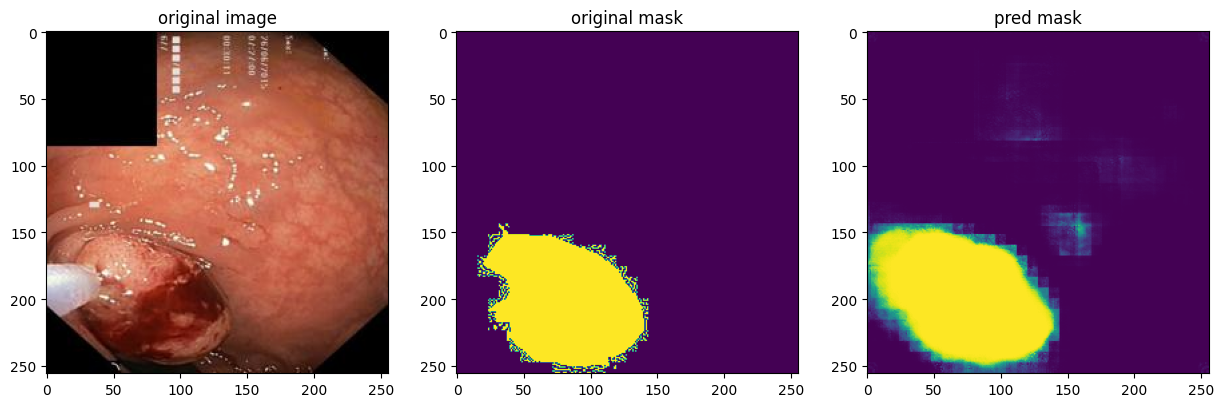

In [27]:
ind = random.randint(0, len(X_test))
img = X_test[ind]
predMask = model_oriu.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image")
ax1.imshow(X_test[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask")
ax2.imshow(np.squeeze(y_test[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask")
ax3.imshow(np.squeeze(predMask))

### **Hyperparameter Tuning**

In [28]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [29]:
# prompt: hyperparameter tuning using kerastuner

import keras_tuner as kt

def build_model(hp):
    input_shape = (256, 256, 3)
    inputs = Input(input_shape)

    # Hyperparameters for the number of filters in each layer
    filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=16)
    filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=32)
    filters_3 = hp.Int('filters_3', min_value=128, max_value=512, step=64)
    filters_4 = hp.Int('filters_4', min_value=256, max_value=1024, step=128)

    s1, p1 = encoder_block(inputs, filters_1)
    s2, p2 = encoder_block(p1, filters_2)
    s3, p3 = encoder_block(p2, filters_3)
    s4, p4 = encoder_block(p3, filters_4)

    b1 = conv_block(p4, hp.Int('bridge_filters', min_value=512, max_value=2048, step=128))

    d1 = decoder_block(b1, s4, filters_4)
    d2 = decoder_block(d1, s3, filters_3)
    d3 = decoder_block(d2, s2, filters_2)
    d4 = decoder_block(d3, s1, filters_1)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")

    # Hyperparameters for learning rate and optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 3e-3, 8e-4])
    optimizer = hp.Choice('optimizer', values=['adamax', 'rmsprop'])

    if optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', iou_coef])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_iou_coef", direction="max"),
    max_trials=5,  # Specify the maximum number of trials
    directory='my_dir',
    project_name='kvasir_tuning',
    overwrite=True
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Trial 5 Complete [00h 15m 10s]
val_iou_coef: 0.6001970171928406

Best val_iou_coef So Far: 0.66796875
Total elapsed time: 00h 59m 04s


In [30]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
282/282 [==============================] - 59s 190ms/step - loss: 11.8777 - accuracy: 0.7593 - iou_coef: 0.1364 - val_loss: 0.5326 - val_accuracy: 0.8203 - val_iou_coef: 0.2097
Epoch 2/20
282/282 [==============================] - 53s 187ms/step - loss: 0.5001 - accuracy: 0.8252 - iou_coef: 0.2371 - val_loss: 0.4047 - val_accuracy: 0.8528 - val_iou_coef: 0.2899
Epoch 3/20
282/282 [==============================] - 53s 187ms/step - loss: 0.4025 - accuracy: 0.8584 - iou_coef: 0.3194 - val_loss: 0.3961 - val_accuracy: 0.8441 - val_iou_coef: 0.3707
Epoch 4/20
282/282 [==============================] - 53s 187ms/step - loss: 0.3105 - accuracy: 0.8904 - iou_coef: 0.4208 - val_loss: 0.3351 - val_accuracy: 0.8743 - val_iou_coef: 0.4608
Epoch 5/20
282/282 [==============================] - 53s 187ms/step - loss: 0.2625 - accuracy: 0.9084 - iou_coef: 0.4894 - val_loss: 0.2232 - val_accuracy: 0.9212 - val_iou_coef: 0.5490
Epoch 6/20
282/282 [==============================] - 53s 187ms/

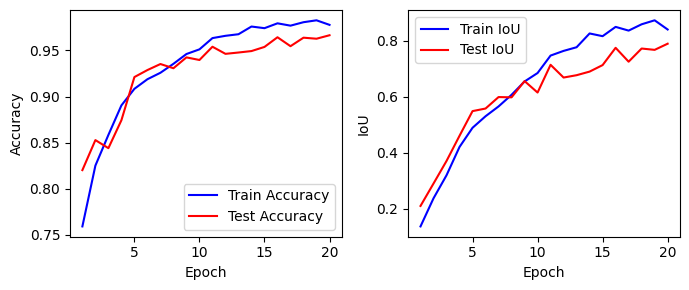

In [31]:
import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
iou2 = history.history['iou_coef']
val_iou = history.history['val_iou_coef']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, iou2,'b',label='Train IoU')
axes[1].plot(epochs, val_iou,'r',label='Test IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [32]:
best_model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/kvasir3_epoch20_tuned.hdf5')